In [ ]:
import xarray as xr # for data handling
import numpy as np # for maths
import matplotlib as mpl # plotlibrary
import matplotlib.pyplot as plt # for the plots 
from matplotlib.colors import LogNorm # for making a log 10 colorscale
import cartopy # library for making maps
from cartopy import crs as ccrs # Projection Library
from cartopy.crs import Stereographic, PlateCarree, Mollweide # Map projections I use
from cartopy.feature import LAND, COASTLINE # Vectordata of the Coastline and land for making the maps prettier

In [ ]:
# Read files (when in same folder as this notebook)
levitus_file = "Levitus_climatology.nc"
levitus = xr.open_dataset(levitus_file, engine="scipy", decode_times=False)
levitus = levitus.rename({"X": "lon", "Y": "lat", "Z": "depth", "T": "month"}) # Rename the dimensions for easier understanding
levitus["month"] = np.ceil(levitus.month.values).astype(int)

ocean_atmosphere_heat_flux_file = "Ocean-atmosphere_heat-flux.nc"
oa_heat_flux = xr.open_dataset(ocean_atmosphere_heat_flux_file, engine="scipy", decode_times=False)
oa_heat_flux = oa_heat_flux.rename({"Y": "lat", "T": "month", "hfns": "heatflux"}) # Rename the dimensions for easier understanding 
oa_heat_flux["month"] = np.ceil(oa_heat_flux.month.values).astype(int)

mimoc_file = "MIMOC_Z_GRID_v2.2_PT_S_month01.nc"
mimoc = xr.open_dataset(mimoc_file, decode_times=False)

In [ ]:
mimoc_var_names_old = list(mimoc.variables.mapping.keys())
mimoc_var_names_new = [variable_name.lower() for variable_name in mimoc_var_names_old]
mimoc_coords = ["latitude", "longitude", "pressure"]
mimoc_dim_names_new = [coord_name[:3] for coord_name in mimoc_coords]
mimoc_dim_names_old = list(mimoc.dims.mapping.keys())
mimoc_dim_names_new
mimoc = (
        mimoc
        .rename_vars(dict(zip(mimoc_var_names_old, mimoc_var_names_new)))
        .set_coords(mimoc_coords)
        .rename_dims(dict(zip(mimoc_dim_names_old, mimoc_dim_names_new)))
        .set_index(indexes=dict(zip(mimoc_dim_names_new, mimoc_coords)))
)

In [ ]:
# Define given values
specific_heat_capacity = 3.94e3
density = 1024

In [ ]:
# Set the basic mapping parameters
suptitle_size = 20 # Size for the main title 
title_size = 16 # Size for fonts
map_size = (16, 4) 
map_projection = Mollweide()

# Define a function that gives basic mapping parameters like land, coastline and gridlines
def basemap(ax):
        ax.add_feature(LAND)
        ax.add_feature(COASTLINE)
        ax.gridlines(
                draw_labels=["left", "bottom"], 
                y_inline=False, x_inline=False
        ) # Labels for  the coordinates are not within the map, but outside
        return ax

In [ ]:
# Integrate Temperature over the topmost 1000 meters
integrated_temperature = (
        levitus
        .sel(depth=slice(0,1000)) # Select only the values within the topmost 1000 meters
        .integrate(coord="depth") # Integrate over the depth
        .temp # Take the Value Temperature
).T # transpose the data 

In [ ]:
# change the coordinates from -180 - 180 to 0 -360
oa_heat_flux_x_coord = oa_heat_flux["X"]
oa_heat_flux_x_coord_less_than_zero = oa_heat_flux_x_coord < 0

oa_heat_flux["lon"] = xr.where(
        oa_heat_flux_x_coord_less_than_zero, # take all the values, where X is less than zero
        oa_heat_flux_x_coord+360, # if true, add 360
        oa_heat_flux_x_coord, # if false take them verbatim
)

oa_heat_flux = (
        oa_heat_flux
        .sortby(["lon", "lat"]) # make sure to sort them
        .swap_dims({"X": "lon"}) # Make the new values to our dimension
        .drop_vars("X") # drop the old Dimension
)

<xarray.Dataset> Size: 3MB
Dimensions:   (month: 12, lat: 170, lon: 360)
Coordinates:
  * month     (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
  * lat       (lat) float32 680B -84.5 -83.5 -82.5 -81.5 ... 81.5 82.5 83.5 84.5
  * lon       (lon) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Data variables:
    heatflux  (month, lat, lon) float32 3MB ...
Attributes:
    Conventions:  COARDS

In [ ]:
# Get the total heat by multiplying eachs month value with the number of days in that month, 
# summing everything and then multiply by 24*60*60, as the unit is given per second
seconds_per_day = 24*60*60
days_in_long_month = 31
days_in_short_month = 30
days_in_february = 28
heatflux_DJF = (
    (oa_heat_flux.heatflux.sel(month=[1, 12]).sum(dim="month")) * days_in_long_month + 
    oa_heat_flux.heatflux.sel(month=2) * days_in_february
    ) * seconds_per_day
heatflux_JJA = (
    (oa_heat_flux.heatflux.sel(month=[7, 8]).sum(dim="month")) * days_in_long_month +
    oa_heat_flux.heatflux.sel(month=6) * days_in_short_month
    ) * seconds_per_day

In [ ]:
# Calculate the Change in ocean heatcontent over JJA (August - June) and DJF (Feb - Dec) respectively
ocean_heatcontent_change_JJA = (
        density * specific_heat_capacity * 
        (
                integrated_temperature.sel(month=8) -
                integrated_temperature.sel(month=6)
        )
)
ocean_heatcontent_change_DJF = (
        density * specific_heat_capacity * 
        (
                integrated_temperature.sel(month=2) -
                integrated_temperature.sel(month=12)
        )
)

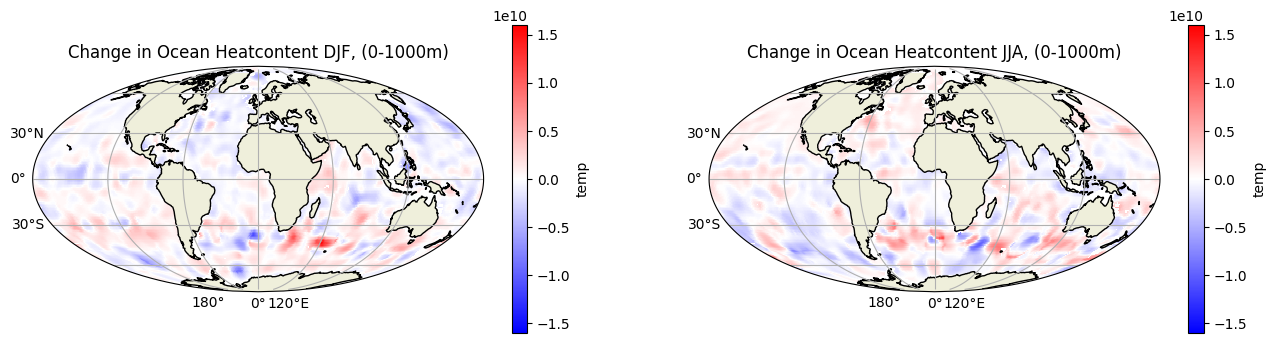

In [ ]:
fig = plt.figure(figsize=map_size)
ax1 = fig.add_subplot(121, projection=Mollweide())
basemap(ax1)
ocean_heatcontent_change_DJF.plot(ax=ax1, transform=PlateCarree(), vmin=-1.6e10, vmax=1.6e10, cmap="bwr")
ax1.set_title("Change in Ocean Heatcontent DJF, (0-1000m)")
ax2 = fig.add_subplot(122, projection=Mollweide())
basemap(ax2)
ocean_heatcontent_change_JJA.plot(ax=ax2, transform=PlateCarree(), vmin=-1.6e10, vmax=1.6e10, cmap="bwr")
ax2.set_title("Change in Ocean Heatcontent JJA, (0-1000m)")
plt.show()

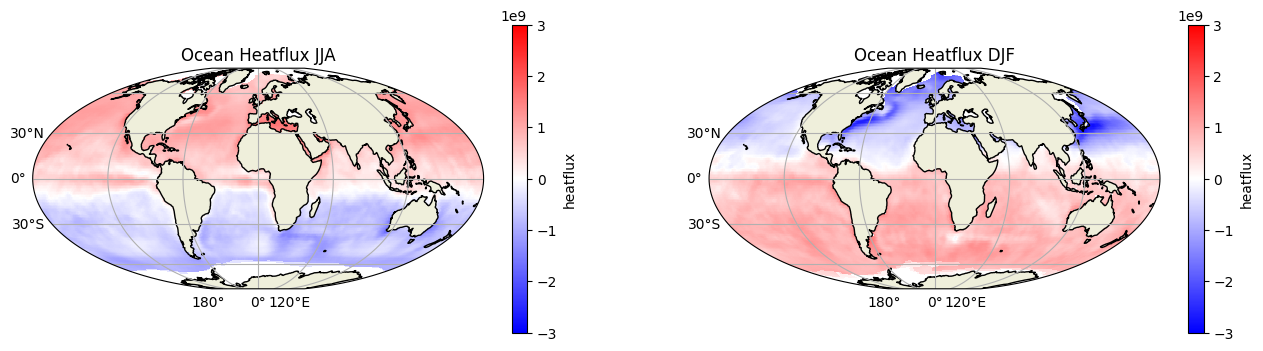

In [ ]:
fig = plt.figure(figsize=map_size)
ax = fig.add_subplot(121, projection=Mollweide())
basemap(ax)
heatflux_JJA.plot(ax=ax, x="lon", y="lat", transform=PlateCarree(), vmin=-3e9, vmax=3e9, cmap="bwr")
ax.set_title("Ocean Heatflux JJA")
ax = fig.add_subplot(122, projection=Mollweide())
basemap(ax)
heatflux_DJF.plot(ax=ax, x="lon", y="lat", transform=PlateCarree(), vmin=-3e9, vmax=3e9, cmap="bwr")
ax.set_title("Ocean Heatflux DJF")
plt.show()

In [38]:
xr.ufuncs.add(heatflux_JJA, ocean_heatcontent_change_JJA)

AlignmentError: cannot align objects with join='exact' where index/labels/sizes are not equal along these coordinates (dimensions): 'lat' ('lat',)

In [25]:
heat_divergence_JJA = (heatflux_JJA + ocean_heatcontent_change_JJA) * (-1)
heat_divergence_DJF = (heatflux_DJF + ocean_heatcontent_change_DJF) * (-1)

KeyboardInterrupt: 

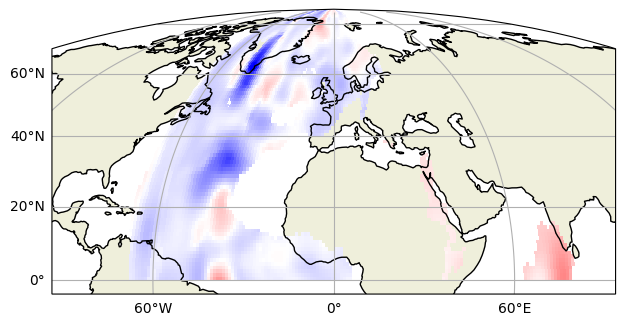

In [26]:
fig = plt.figure(figsize=map_size)
ax = fig.add_subplot(121, projection=Mollweide())
basemap(ax)
heat_divergence_DJF.plot(ax=ax, transform=PlateCarree(), vmin=-1.5e10, vmax=1.5e10, cmap="bwr")
ax.set_title("Heat Divergence DJF")
ax2 = fig.add_subplot(122, projection=Mollweide())
basemap(ax2)
heat_divergence_JJA.plot(ax=ax2, transform=PlateCarree(), vmin=-1.5e10, vmax=1.5e10, cmap="bwr")
ax2.set_title("Heat Divergence JJA")
plt.show()

316.5 304.5
indicies: 30 255 281 609 633


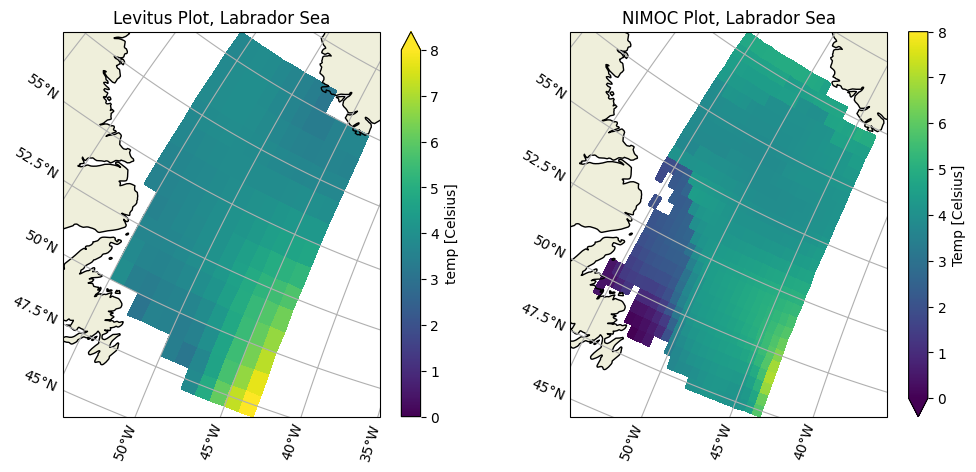

In [22]:
# Exercise 2.a.1a
# depth 200m, 
# The International Hydrographic Organization defines the limits of the Labrador Sea as follows:[7]
#     On the North: the South limit of Davis Strait [The parallel of 60° North between Greenland and Labrador].
#     On the East: a line from Cape St. Francis 47°45′N 52°27′W (Newfoundland) to Cape Farewell (Greenland) 59.7792° N, 43.9117° W.
#     On the West: the East Coast of Labrador and Newfoundland and the Northeast limit of the Gulf of St. Lawrence 
#       – a line running from Cape Bauld (North point of Kirpon Island, 51°40′N 55°25′W) to the East extreme of Belle Isle 
#       and on to the Northeast Ledge (52°02′N 55°15′W). Thence a line joining this ledge with the East extreme of Cape St. Charles (52°13'N) in Labrador.
# source: wikipedia

pressure = 200
latitude1 = 47.5
latitude2 = 60.5
longitude1 = 43.5
longitude2 = 55.5

def coord_west_to_east(west):
    return 360-west

long1 = coord_west_to_east(longitude1)
long2 = coord_west_to_east(longitude2)
print(long1, long2)

labrador_levitus = levitus.sel(Z=pressure, T=0.5, Y=slice(latitude1, latitude2), X=slice(long2, long1)).temp.T

pres = np.where(mimoc.PRESSURE.values == pressure)[0][0]
lat1 = np.where(mimoc.LATITUDE.values == latitude1)[0][0]
lat2 = np.where(mimoc.LATITUDE.values == latitude2)[0][0]
lon1 = np.where(mimoc.LONGITUDE.values == long2)[0][0]
lon2 = np.where(mimoc.LONGITUDE.values == long1)[0][0]
print("indicies:", pres, lat1, lat2, lon1, lon2)

labrador_mimoc = mimoc.set_coords(names=["LATITUDE", "LONGITUDE", "PRESSURE"])                              
labrador_mimoc = labrador_mimoc.isel(PRES=pres, LAT=slice(lat1, lat2+1), LONG=slice(lon1, lon2+1)) 
# The plus one adjustment is to make lat/lon boundaries match because we're working with double resolution data

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(121, projection=ccrs.Stereographic())
basemap(ax)
labrador_levitus.plot(ax=ax, vmin=0, vmax=8, transform=PlateCarree())
ax.set_title("Levitus Plot, Labrador Sea")
ax2 = fig.add_subplot(122, projection=ccrs.Stereographic())
basemap(ax2)
labrador_mimoc.POTENTIAL_TEMPERATURE.plot(ax=ax2, x="LONGITUDE", y="LATITUDE", vmin=0, vmax=8, transform=PlateCarree(), cbar_kwargs={'label': "Temp [Celsius]"})
ax2.set_title("NIMOC Plot, Labrador Sea")
plt.show()

In [118]:
mimoc

<xarray.Dataset> Size: 159MB
Dimensions:                (pre: 81, lat: 341, lon: 720)
Coordinates:
  * pre                    (pre) float32 324B 0.0 5.0 10.0 ... 1.9e+03 1.95e+03
  * lat                    (lat) float32 1kB -80.0 -79.5 -79.0 ... 89.5 90.0
  * lon                    (lon) float32 3kB 0.0 0.5 1.0 ... 358.5 359.0 359.5
Data variables:
    salinity               (pre, lat, lon) float32 80MB ...
    potential_temperature  (pre, lat, lon) float32 80MB ...

In [190]:
north, south, east, west = 80, 45, 350, 280
map_projection_greenland = Stereographic(central_longitude=(east+west)/2, central_latitude=(north-south)/2)

In [198]:
def longitude_180_to_360(longitude):
        return longitude+360

labrador_extent = {
        "north": 60.5,
        "south": 47.5,
        "west": longitude_180_to_360(-55.5),
        "east": longitude_180_to_360(-43.5),
}
irminger_extent = {
        "north": 65.5,
        "south": 59.5,
        "west": longitude_180_to_360(-43.5),
        "east": longitude_180_to_360(-19.5),
}

depth_extent = pressure_extent*10

In [ ]:
levitus_labrador = (
        levitus
        .sel(depth=depth_extent, month=1, method="nearest")
        .sel(
                lat=slice(labrador_extent["south"], labrador_extent["north"]),
                lon=slice(labrador_extent["west"], labrador_extent["east"]),
        )
).temp
mimoc_labrador = mimoc.sel(pre=pressure_extent, method="nearest").sel(
                lat=slice(labrador_extent["south"], labrador_extent["north"]),
                lon=slice(labrador_extent["west"], labrador_extent["east"]),
        ).potential_temperature

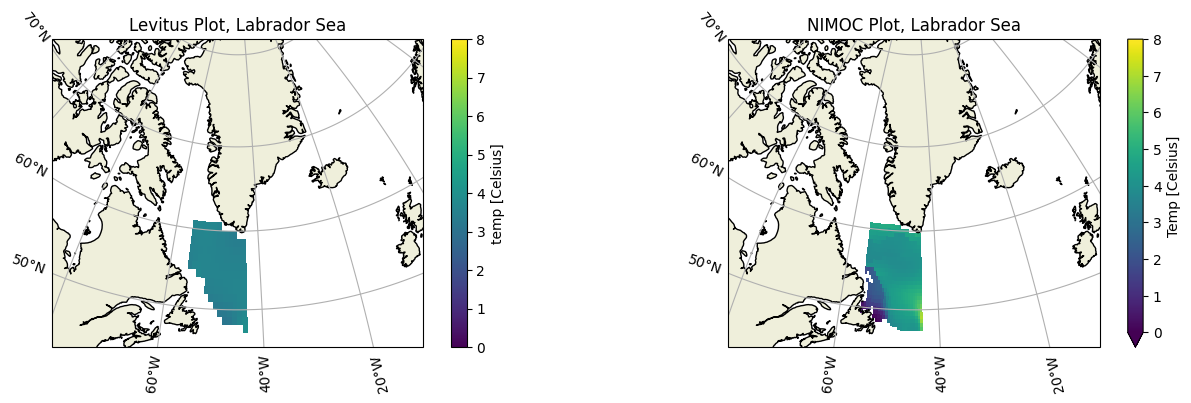

In [191]:
# Exercise 2.a.1a
# depth 200m, 
# The International Hydrographic Organization defines the limits of the Labrador Sea as follows:[7]
#     On the North: the South limit of Davis Strait [The parallel of 60° North between Greenland and Labrador].
#     On the East: a line from Cape St. Francis 47°45′N 52°27′W (Newfoundland) to Cape Farewell (Greenland) 59.7792° N, 43.9117° W.
#     On the West: the East Coast of Labrador and Newfoundland and the Northeast limit of the Gulf of St. Lawrence 
#       – a line running from Cape Bauld (North point of Kirpon Island, 51°40′N 55°25′W) to the East extreme of Belle Isle 
#       and on to the Northeast Ledge (52°02′N 55°15′W). Thence a line joining this ledge with the East extreme of Cape St. Charles (52°13'N) in Labrador.
# source: wikipedia

fig = plt.figure(figsize=map_size)
ax1 = fig.add_subplot(121, projection=map_projection_greenland)
basemap(ax1)
ax1.set_extent([west, east, south, north], crs=PlateCarree())
levitus_labrador.plot(ax=ax1, x="lon", y="lat", vmin=0, vmax=8, transform=PlateCarree())
ax1.set_title("Levitus Plot, Labrador Sea")
ax2 = fig.add_subplot(122, projection=map_projection_greenland)
basemap(ax2)
ax2.set_extent([west, east, south, north], crs=PlateCarree())
mimoc_labrador.plot(ax=ax2, x="lon", y="lat", vmin=0, vmax=8, transform=PlateCarree(), cbar_kwargs={'label': "Temp [Celsius]"})
ax2.set_title("NIMOC Plot, Labrador Sea")
plt.show()

In [199]:
levitus_irminger = (
        levitus
        .sel(depth=depth_extent, month=1, method="nearest")
        .sel(
                lat=slice(irminger_extent["south"], irminger_extent["north"]),
                lon=slice(irminger_extent["west"], irminger_extent["east"]),
        )
).temp
mimoc_irminger = mimoc.sel(pre=pressure_extent, method="nearest").sel(
                lat=slice(irminger_extent["south"], irminger_extent["north"]),
                lon=slice(irminger_extent["west"], irminger_extent["east"]),
        ).potential_temperature

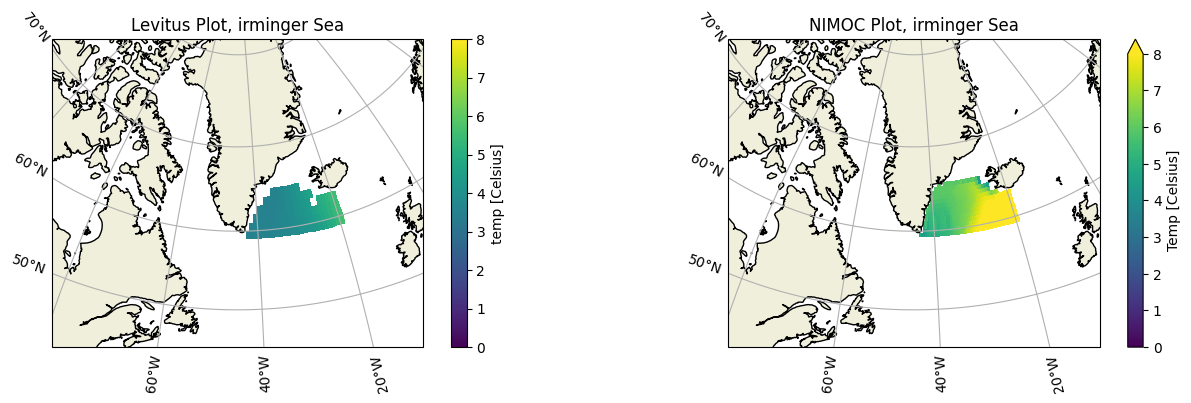

In [200]:
fig = plt.figure(figsize=map_size)
ax1 = fig.add_subplot(121, projection=map_projection_greenland)
basemap(ax1)
ax1.set_extent([west, east, south, north], crs=PlateCarree())
levitus_irminger.plot(ax=ax1, x="lon", y="lat", vmin=0, vmax=8, transform=PlateCarree())
ax1.set_title("Levitus Plot, irminger Sea")
ax2 = fig.add_subplot(122, projection=map_projection_greenland)
basemap(ax2)
ax2.set_extent([west, east, south, north], crs=PlateCarree())
mimoc_irminger.plot(ax=ax2, x="lon", y="lat", vmin=0, vmax=8, transform=PlateCarree(), cbar_kwargs={'label': "Temp [Celsius]"})
ax2.set_title("NIMOC Plot, irminger Sea")
plt.show()

In [ ]:
temp_profile_lat = 51.5
temp_profile_lon = longitude_180_to_360(-47.5)
mimoc_temp_profile = mimoc.sel(lat=temp_profile_lat, lon= temp_profile_lon, method="nearest")
levitus_temp_profile = levitus.sel(lat=temp_profile_lat, lon= temp_profile_lon, month=1, method="nearest")

In [240]:
mimoc

<xarray.Dataset> Size: 159MB
Dimensions:                (pre: 81, lat: 341, lon: 720)
Coordinates:
  * pre                    (pre) float32 324B 0.0 5.0 10.0 ... 1.9e+03 1.95e+03
  * lat                    (lat) float32 1kB -80.0 -79.5 -79.0 ... 89.5 90.0
  * lon                    (lon) float32 3kB 0.0 0.5 1.0 ... 358.5 359.0 359.5
Data variables:
    salinity               (pre, lat, lon) float32 80MB ...
    potential_temperature  (pre, lat, lon) float32 80MB ...

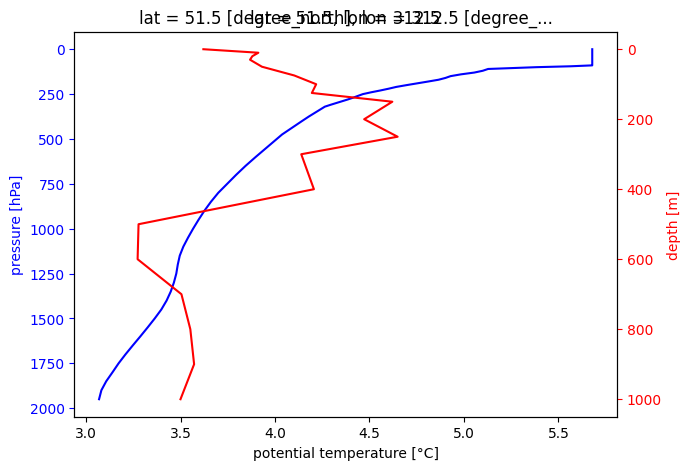

In [ ]:
fig = plt.figure(figsize=(7, 5))
ax_mimoc = fig.add_subplot()
ax_mimoc.invert_yaxis()
mimoc_temp_profile.potential_temperature.plot(ax=ax_mimoc, y="pre", c="b")
ax_mimoc.set_ylabel("pressure [hPa]", color="b")
ax_mimoc.set_xlabel("potential temperature [°C]", color="k")
ax_mimoc.tick_params(axis="y", colors="b")

ax_levitus = ax_mimoc.twinx()
ax_levitus.invert_yaxis()
levitus_temp_profile.temp.plot(ax=ax_levitus, y="depth", c="r")
ax_levitus.set_ylabel("depth [m]", color="r")
ax_levitus.tick_params(colors="r")
plt.show()

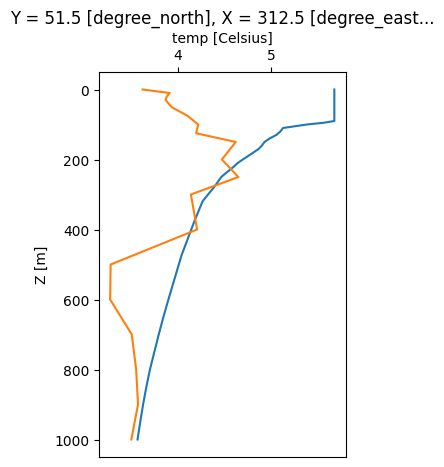

In [ ]:
# Exercise 2.a.2.a
# Temperature Profile at 51.5N 47.5W

def coord_west_to_east(west):
    return 360-west


lat_index = np.where(mimoc.LATITUDE.values == lat)[0][0]
lon_index = np.where(mimoc.LONGITUDE.values == lon)[0][0]
pressure_max = np.where(mimoc.PRESSURE.values == 1000)[0][0]

lab_lev = levitus.sel(T=0.5, X=lon, Y=lat).temp
lab_iso = mimoc.set_coords(names=["LATITUDE", "LONGITUDE", "PRESSURE"])
lab_iso = lab_iso.sel(LAT=lat_index, LONG=lon_index, PRES=slice(0, pressure_max+1)).POTENTIAL_TEMPERATURE

fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(121)
lab_iso.plot(y="PRESSURE")
lab_lev.plot(y="Z")
ax.invert_yaxis()
ax.xaxis.set_label_position('top') 
ax.xaxis.tick_top()

# Make more pretty if submitting




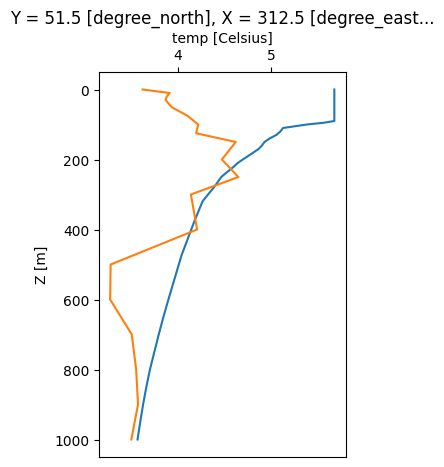

In [ ]:
# Exercise 2.a.2.a
# Temperature Profile at 51.5N 47.5W

def coord_west_to_east(west):
    return 360-west

temp_profile_lat = 51.5
temp_profile_lon = longitude_180_to_360(/47.5)
lat_index = np.where(mimoc.LATITUDE.values == lat)[0][0]
lon_index = np.where(mimoc.LONGITUDE.values == lon)[0][0]
pressure_max = np.where(mimoc.PRESSURE.values == 1000)[0][0]

lab_lev = levitus.sel(T=0.5, X=lon, Y=lat).temp
lab_iso = mimoc.set_coords(names=["LATITUDE", "LONGITUDE", "PRESSURE"])
lab_iso = lab_iso.sel(LAT=lat_index, LONG=lon_index, PRES=slice(0, pressure_max+1)).POTENTIAL_TEMPERATURE

fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(121)
lab_iso.plot(y="PRESSURE")
lab_lev.plot(y="Z")
ax.invert_yaxis()
ax.xaxis.set_label_position('top') 
ax.xaxis.tick_top()

# Make more pretty if submitting




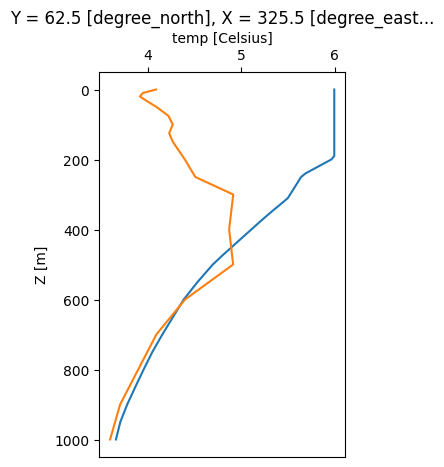

In [ ]:
# Exercise 2.a.2.b
# Temperature Profile at 62.5N 34.5W

def w_to_e(west):
    coord_rest_to_east 360-west

lat = 62.5
lon = w_to_e(34.5)
lat_incoord_dest_to_eastnp.where(mimoc.LATITUDE.values == lat)[0][0]
lon_index = np.where(mimoc.LONGITUDE.values == lon)[0][0]
pressure_max = np.where(mimoc.PRESSURE.values == 1000)[0][0]

lab_lev = levitus.sel(T=0.5, X=lon, Y=lat).temp
lab_iso = mimoc.set_coords(names=["LATITUDE", "LONGITUDE", "PRESSURE"])
lab_iso = lab_iso.sel(LAT=lat_index, LONG=lon_index, PRES=slice(0, pressure_max+1)).POTENTIAL_TEMPERATURE

fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(121)
lab_iso.plot(y="PRESSURE")
lab_lev.plot(y="Z")
ax.invert_yaxis()
ax.xaxis.set_label_position('top') 
ax.xaxis.tick_top()

# Make more pretty if submitting

340.5 316.5


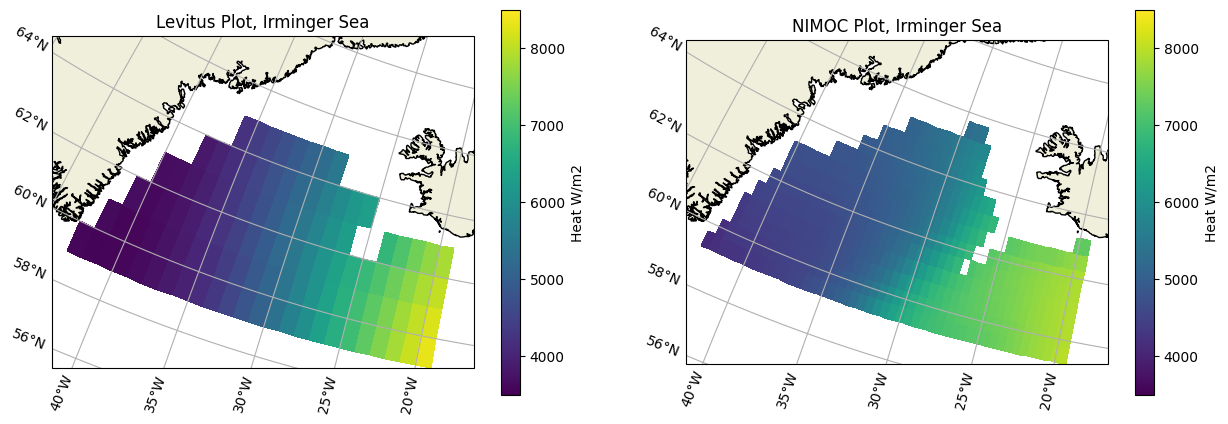

In [ ]:
# Exercise 2.a.3.a

latitude1 = 59.5
latitude2 = 65.5
longitude1 = 19.5
longitude2 = 43.5

def w_to_e(west):
    coord_rest_to_east 360-west

long1 = w_to_e(longitude1)
long2 = coord_west_to_east(longitude2)
print(locoord_nest_to_eastong2)

irminger_levitus = levitus.sel(T=0.5, Y=slice(latitude1, latitude2), X=slice(long2, long1)).integrate(coord="Z").temp.T

lat1 = np.where(mimoc.LATITUDE.values == latitude1)[0][0]
lat2 = np.where(mimoc.LATITUDE.values == latitude2)[0][0]
lon1 = np.where(mimoc.LONGITUDE.values == long2)[0][0]
lon2 = np.where(mimoc.LONGITUDE.values == long1)[0][0]
pressure_max = np.where(mimoc.PRESSURE.values == 1000)[0][0]

irminger_mimoc = mimoc.set_coords(names=["LATITUDE", "LONGITUDE", "PRESSURE"])                              
irminger_mimoc = irminger_mimoc.isel(PRES=slice(0, pressure_max+1), LAT=slice(lat1, lat2+1), LONG=slice(lon1, lon2+1)).integrate(coord="PRESSURE").POTENTIAL_TEMPERATURE
# The plus one adjustment is to make lat/lon boundaries match because we're working with double resolution data

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(121, projection=ccrs.Stereographic())
basemap(ax)
irminger_levitus.plot(ax=ax, transform=PlateCarree(), vmin=3500, vmax=8500, cbar_kwargs={'label': "Heat W/m2"})
ax.set_title("Levitus Plot, Irminger Sea")
ax2 = fig.add_subplot(122, projection=ccrs.Stereographic())
basemap(ax2)
irminger_mimoc.plot(ax=ax2, x="LONGITUDE", y="LATITUDE", transform=PlateCarree(), vmin=3500, vmax=8500, cbar_kwargs={'label': "Heat W/m2"})
ax2.set_title("NIMOC Plot, Irminger Sea")
plt.show()

340.5 316.5


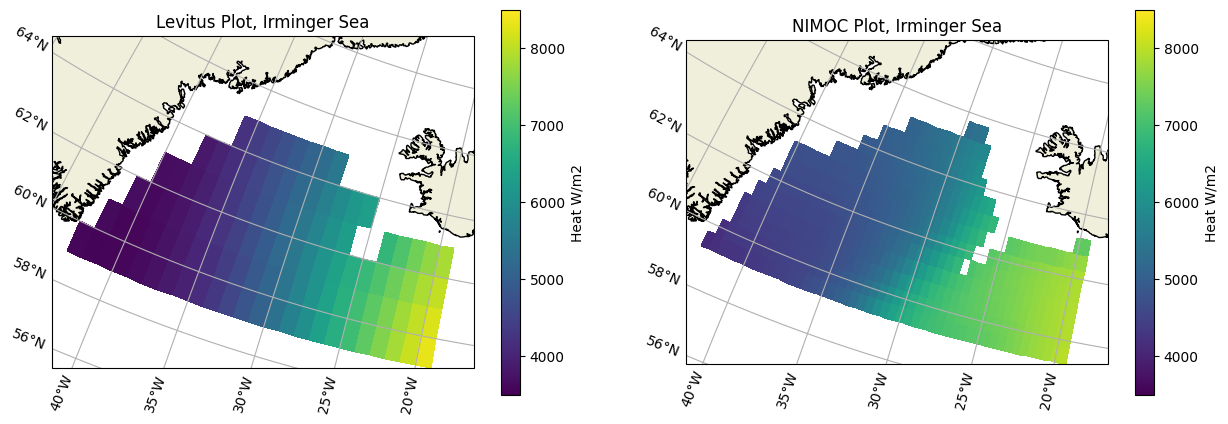

In [ ]:
# Exercise 2.a.3.b

latitude1 = 59.5
latitude2 = 65.5
longitude1 = 19.5
longitude2 = 43.5

def w_to_e(west):
    coord_rest_to_east 360-west

long1 = w_to_e(longitude1)
long2 = coord_west_to_east(longitude2)
print(locoord_nest_to_eastong2)

irminger_levitus = levitus.sel(T=0.5, Y=slice(latitude1, latitude2), X=slice(long2, long1)).integrate(coord="Z").temp.T

lat1 = np.where(mimoc.LATITUDE.values == latitude1)[0][0]
lat2 = np.where(mimoc.LATITUDE.values == latitude2)[0][0]
lon1 = np.where(mimoc.LONGITUDE.values == long2)[0][0]
lon2 = np.where(mimoc.LONGITUDE.values == long1)[0][0]
pressure_max = np.where(mimoc.PRESSURE.values == 1000)[0][0]

irminger_mimoc = mimoc.set_coords(names=["LATITUDE", "LONGITUDE", "PRESSURE"])                              
irminger_mimoc = irminger_mimoc.isel(PRES=slice(0, pressure_max+1), LAT=slice(lat1, lat2+1), LONG=slice(lon1, lon2+1)).integrate(coord="PRESSURE").POTENTIAL_TEMPERATURE
# The plus one adjustment is to make lat/lon boundaries match because we're working with double resolution data

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(121, projection=ccrs.Stereographic())
basemap(ax)
irminger_levitus.plot(ax=ax, transform=PlateCarree(), vmin=3500, vmax=8500, cbar_kwargs={'label': "Heat W/m2"})
ax.set_title("Levitus Plot, Irminger Sea")
ax2 = fig.add_subplot(122, projection=ccrs.Stereographic())
basemap(ax2)
irminger_mimoc.plot(ax=ax2, x="LONGITUDE", y="LATITUDE", transform=PlateCarree(), vmin=3500, vmax=8500, cbar_kwargs={'label': "Heat W/m2"})
ax2.set_title("NIMOC Plot, Irminger Sea")
plt.show()